### Astrobase core stuff

This notebook remixes Waqas Bhatti's `lightcurve-work.ipynb` notebook to analyze HAT's observations of Kepler 16. It uses the `hatlc`, `periodbase`, and `plotbase` modules to read in HAT light curves, run period searches, and plot the results. The `nb-data` subdirectory in the `notebooks` folder contains some sample HAT light curves to use for this work.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from astrobase import hatlc, periodbase, plotbase, lcmath

What is actually in the `/H/4KRED/AP/4KAP_LC/115` directory? (it's ~388k files, so ls is a bit uncooperative). Answer from quick python scripting: it's stuff that ends with: `.epdlc`, `pdlog`, `rlc`, `tfalc`, and `tmp`. So it's not the HAT produced-CSV light curve, nor is it a `sqlitecurve`. More specifically (we ssh'd these LCs over to work locally):

In [2]:
pwd

'/home/luke/Dropbox/proj/hat/src/sandbox/notebooks'

In [3]:
ls ../../../data/kepler_16/

HAT-115-0003266.epdlc   HAT-115-0003266.rlc
HAT-115-0003266.epdlog  HAT-115-0003266.tfalc


In [4]:
! head ../../../data/kepler_16/HAT-115-0003266.epdlc # notice ! lets you run shell commands directly...

# Generated by fiastrom.sh HATpipe SVN version 997
7-173419   55089.6967013 11.51299  0.00665  G 11.17438  0.00584  G 10.99055  0.00549  G  11.1914  10.8839  10.7499 11.84265 11.82917 11.82304
7-173420   55089.6994597 11.42803  0.00621  G 11.09591  0.00543  G 10.92023  0.00510  G   11.183  10.8726  10.7384 11.83379 11.82157 11.81585
7-173421   55089.7021795 11.41373  0.00621  G 11.08811  0.00546  G 10.91634  0.00514  G  11.1767  10.8592  10.7178 11.79301 11.78995 11.78795
7-173422   55089.7049574 11.57461  0.00666  G 11.26627  0.00590  G 11.10733  0.00560  G    11.16  10.8521  10.7164 11.79857 11.79302 11.79082
7-173425   55089.7129895 11.74045  0.00737  G 11.44151  0.00662  G 11.29102  0.00635  G  11.1473  10.8352  10.6956 11.82450 11.80296 11.78834
7-173426   55089.7155704 11.67144  0.00694  G 11.39150  0.00624  G 11.24490  0.00595  G  11.1218  10.8268  10.6887 11.78507 11.78107 11.77385
7-173427   55089.7183717 11.61300  0.00671  G 11.32304  0.00599  G 11.17346  0.00570  G  11.1369 

We added the `read_text_lc` module to `hatlc`, now let's use it:

In [5]:
lcd = hatlc.read_text_lc('../../../data/kepler_16/HAT-115-0003266.epdlc')

2016-12-21T15:36:06.530942Z [INFO]: reading HATLC: ../../../data/kepler_16/HAT-115-0003266.epdlc
2016-12-21T15:36:06.531173Z [INFO]: Using 17 column names (format appropriate for data)


In [6]:
lcd

{'BJDc': array([ 55089.6967013,  55089.6994597,  55089.7021795, ...,  54723.9631491,
         54723.9674197,  54724.9126296]),
 'MEPD0': array([ 11.84265,  11.83379,  11.79301, ...,  11.78935,  11.77645,
         11.79797]),
 'MEPD1': array([ 11.82917,  11.82157,  11.78995, ...,  11.78392,  11.7758 ,
         11.79198]),
 'MEPD2': array([ 11.82304,  11.81585,  11.78795, ...,  11.78324,  11.77574,
         11.78703]),
 'MFIT0': array([ 11.1914,  11.183 ,  11.1767, ...,  11.1145,  11.0979,  11.0989]),
 'MFIT1': array([ 10.8839,  10.8726,  10.8592, ...,  10.82  ,  10.8237,  10.8169]),
 'MFIT2': array([ 10.7499,  10.7384,  10.7178, ...,  10.6946,  10.7006,  10.6942]),
 'MRAW0': array([ 11.51299,  11.42803,  11.41373, ...,  11.63001,  11.57288,
         11.79658]),
 'MRAW1': array([ 11.17438,  11.09591,  11.08811, ...,  11.29334,  11.26776,
         11.39724]),
 'MRAW2': array([ 10.99055,  10.92023,  10.91634, ...,  11.13792,  11.12973,
         11.18643]),
 'MRAWERR0': array([ 0.00665,  0.

In [7]:
hatlc.describe(lcd)

KeyError: 'columns'

So note that we did break, for instance, the .describe() function of the standard hatlcs. But that said... these ones have different metadata! So OFC we broke it...

Metadata that concerns us:
```
LIGHT CURVE COLUMNS
-------------------

000 - rjd - time of observation in Reduced Julian date (JD = 2400000.0 + RJD)
001 - bjd - time of observation in Baryocentric Julian date (note: this is BJD_TDB)
002 - net - network of telescopes observing this target
003 - stf - station ID of the telescope observing this target
004 - cfn - camera frame serial number
005 - cfs - camera subframe id
006 - ccd - camera CCD position number
007 - prj - project ID of this observation
008 - fld - observed field name
009 - frt - image frame type (flat, object, etc.)
010 - flt - filter ID from the filters table
011 - exp - exposure time for this observation in seconds
012 - tfs - telescope focus setting
013 - ttt - telescope tube temperature [deg]
014 - tms - telescope mount state (tracking, drizzling, etc.)
015 - mph - moon phase at this observation
016 - iha - hour angle of object at this observation
017 - izd - zenith distance of object at this observation
018 - xcc - x coordinate on CCD chip
019 - ycc - y coordinate on CCD chip
020 - bgv - sky background measurement around object in ADU
021 - bge - error in sky background measurement in ADU
022 - fsv - source extraction S parameter (the PSF spatial RMS)
023 - fdv - source extraction D parameter (the PSF spatial ellipticity in xy)
024 - fkv - source extraction K parameter (the PSF spatial diagonal ellipticity)
025 - aim_000 - aperture photometry raw instrumental magnitude in aperture 000
026 - aie_000 - aperture photometry raw instrumental mag error in aperture 000
027 - aiq_000 - aperture photometry raw instrumental mag quality flag for aperture 000
028 - aim_001 - aperture photometry raw instrumental magnitude in aperture 001
029 - aie_001 - aperture photometry raw instrumental mag error in aperture 001
030 - aiq_001 - aperture photometry raw instrumental mag quality flag for aperture 001
031 - aim_002 - aperture photometry raw instrumental magnitude in aperture 002
032 - aie_002 - aperture photometry raw instrumental mag error in aperture 002
033 - aiq_002 - aperture photometry raw instrumental mag quality flag for aperture 002
034 - arm_000 - aperture photometry fit magnitude in aperture 000
035 - arm_001 - aperture photometry fit magnitude in aperture 001
036 - arm_002 - aperture photometry fit magnitude in aperture 002
037 - aep_000 - aperture photometry EPD magnitude in aperture 000
038 - aep_001 - aperture photometry EPD magnitude in aperture 001
039 - aep_002 - aperture photometry EPD magnitude in aperture 002
040 - atf_000 - aperture photometry TFA magnitude in aperture 000
041 - atf_001 - aperture photometry TFA magnitude in aperture 001
042 - atf_002 - aperture photometry TFA magnitude in aperture 002
```

In [8]:
# the columns are all numpy arrays
lcd.keys()

dict_keys(['BJDc', 'MRAWERR0', 'MRAWERR2', 'MRAW1', 'MFIT1', 'MFIT2', 'PHOTFLAG0', 'PHOTFLAG1', 'MRAW0', 'MEPD0', 'PHOTFLAG2', 'MFIT0', 'MEPD1', 'MRAW2', 'MRAWERR1', 'SOME_ID', 'MEPD2'])

In [9]:
lcd['BJDc']

array([ 55089.6967013,  55089.6994597,  55089.7021795, ...,  54723.9631491,
        54723.9674197,  54724.9126296])

## Running period finding operations

For the standard `hatlc.read_and_filter_sqlitecurve` and `hatlc.read_csvlc`, we could directly use `hatlc.normalize_lcdict`. 

However, that method (`normalize_lcdict`) makes a bunch of assumptions about input dictionary format. For the cases in which we're interested, those assumptions aren't met.

Waqas recommends: `lcmath.normalize_magseries`.

In [17]:
time, mepd1 = lcmath.normalize_magseries(lcd['BJDc'], lcd['MEPD1'])

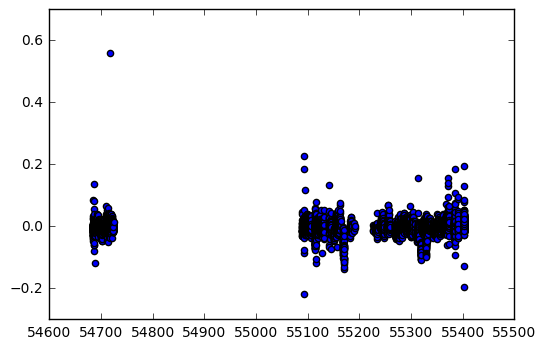

In [18]:
f, ax = plt.subplots()
ax.scatter(time, mepd1);

Ok, but now to run generalized Lomb Scorgle, or any of the period finding methods, we need errors.
(N.b. later, we also need to use the optimal aperture. Here we use "1", which is a 3 px radius aperture. "0" is a 2px radius aperture, and "2" is a 4px radius aperture.)

-> Just use `MRAWERR1`, although it's not clear that this is correct.

In [19]:
# next, break out the columns we'll use for the period-finding
# we'll use reduced JD as the times, 
# EPD magnitude in the smallest aperture as the mags, 
# and magnitude errors in the smallest aperture as the errs
times, mags, errs = time, mepd1, lcd['MRAWERR1']

In [20]:
# let's run Lomb-Scargle
glsp = periodbase.pgen_lsp(times,mags,errs)

2016-12-21T15:41:42.333321Z [INFO]: sigclip = 10.0: before = 9569 observations, after = 9553 observations
2016-12-21T15:41:42.334239Z [INFO]: using autofreq with 35907 frequency points, start P = 0.100, end P = 718.235
2016-12-21T15:41:42.334280Z [INFO]: using 16 workers...


In order to use the fancy `plotbase.make_checkplot`, we need our light curve dictionary (or, the normalized one) to have objectinfo metadata... this would originally be in `normlcd['objectinfo']`, and look like:
```
{'bmag': 17.744,
 'decl': -56.816551,
 'hatid': 'HAT-772-0554686',
 'hmag': 12.65,
 'jmag': 13.303,
 'kmag': 12.461,
 'ndet': 11261,
 'network': 'HS',
 'pmdecl': -6.2,
 'pmdecl_err': 2.9,
 'pmra': 3.6,
 'pmra_err': 2.9,
 'ra': 219.450491,
 'sdssg': 16.867,
 'sdssi': 14.909,
 'sdssr': 15.648,
 'stations': 'HS02,HS04,HS06',
 'twomassid': '14374811-5648595 ',
 'ucac4id': '21965424',
 'vmag': 16.083}
 ```

In [22]:
len(mags)

9569

In [24]:
# https://hatsurveys.org/lightcurves/object/HAT-115-0003266
obj_info = {'bmag': 13.675, 'decl': 51.757, 'hatid': 'HAT-115-0003266','hmag': 9.137, 'jmag': 9.815,
 'kmag': 8.996, 'ndet': 9569, 'network': 'HN', 'pmdecl': -49.2, 'pmdecl_err': 2, 'pmra': 10.5,
 'pmra_err': 2.4, 'ra': 289.076, 'sdssg': 12.965, 'sdssi': 11.127, 'sdssr': 11.718, 
 'stations': 'not_sure', 'twomassid': '19161817+5145267', 'vmag': 12.283}

In [25]:
# let's make a checkplot to see the periods associated with the best spectrogram peaks
# this also gives a quick overview of the object information and gets a finder chart from NASA's SkyView service
cp = plotbase.make_checkplot(glsp, times, mags, errs, objectinfo=obj_info)

2016-12-21T15:56:05.875264Z [INFO]: adding in object information and finder chart for HAT-115-0003266 at RA: 289.076, DEC: 51.757


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2016-12-21T15:56:10.001376Z [INFO]: sigclip = 4.0: before = 9569 observations, after = 9338 observations
2016-12-21T15:56:10.050893Z [INFO]: sigclip = 30.0: before = 9338 observations, after = 9338 observations
2016-12-21T15:56:10.058637Z [INFO]: spline fit done. nknots = 93,  chisq = 49920.84363, reduced chisq = 5.40035
2016-12-21T15:56:10.058750Z [INFO]: plotting phased LC with period 34.201688, epoch 54712.75489
2016-12-21T15:56:11.018007Z [INFO]: plotting phased LC with period 17.100844, epoch 54712.75489
2016-12-21T15:56:12.004855Z [INFO]: plotting phased LC with period 68.403377, epoch 54712.75489
2016-12-21T15:56:13.050916Z [INFO]: plotting phased LC with period 1.026931, epoch 54712.75489
2016-12-21T15:56:14.033215Z [INFO]: plotting phased LC with period 34.530551, epoch 54712.75489
2016-12-21T15:56:14.960007Z [INFO]: plotting phased LC with period 33.879031, epoch 54712.75489
2016-12-21T15:56:15.876840Z [INFO]: plotting phased LC with period 36.274518, epoch 54712.75489


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


2016-12-21T15:56:20.924357Z [INFO]: checkplot done -> checkplot.png


In [26]:
# to see the checkplot, let's use ipython's built in image viewer
from IPython.display import Image

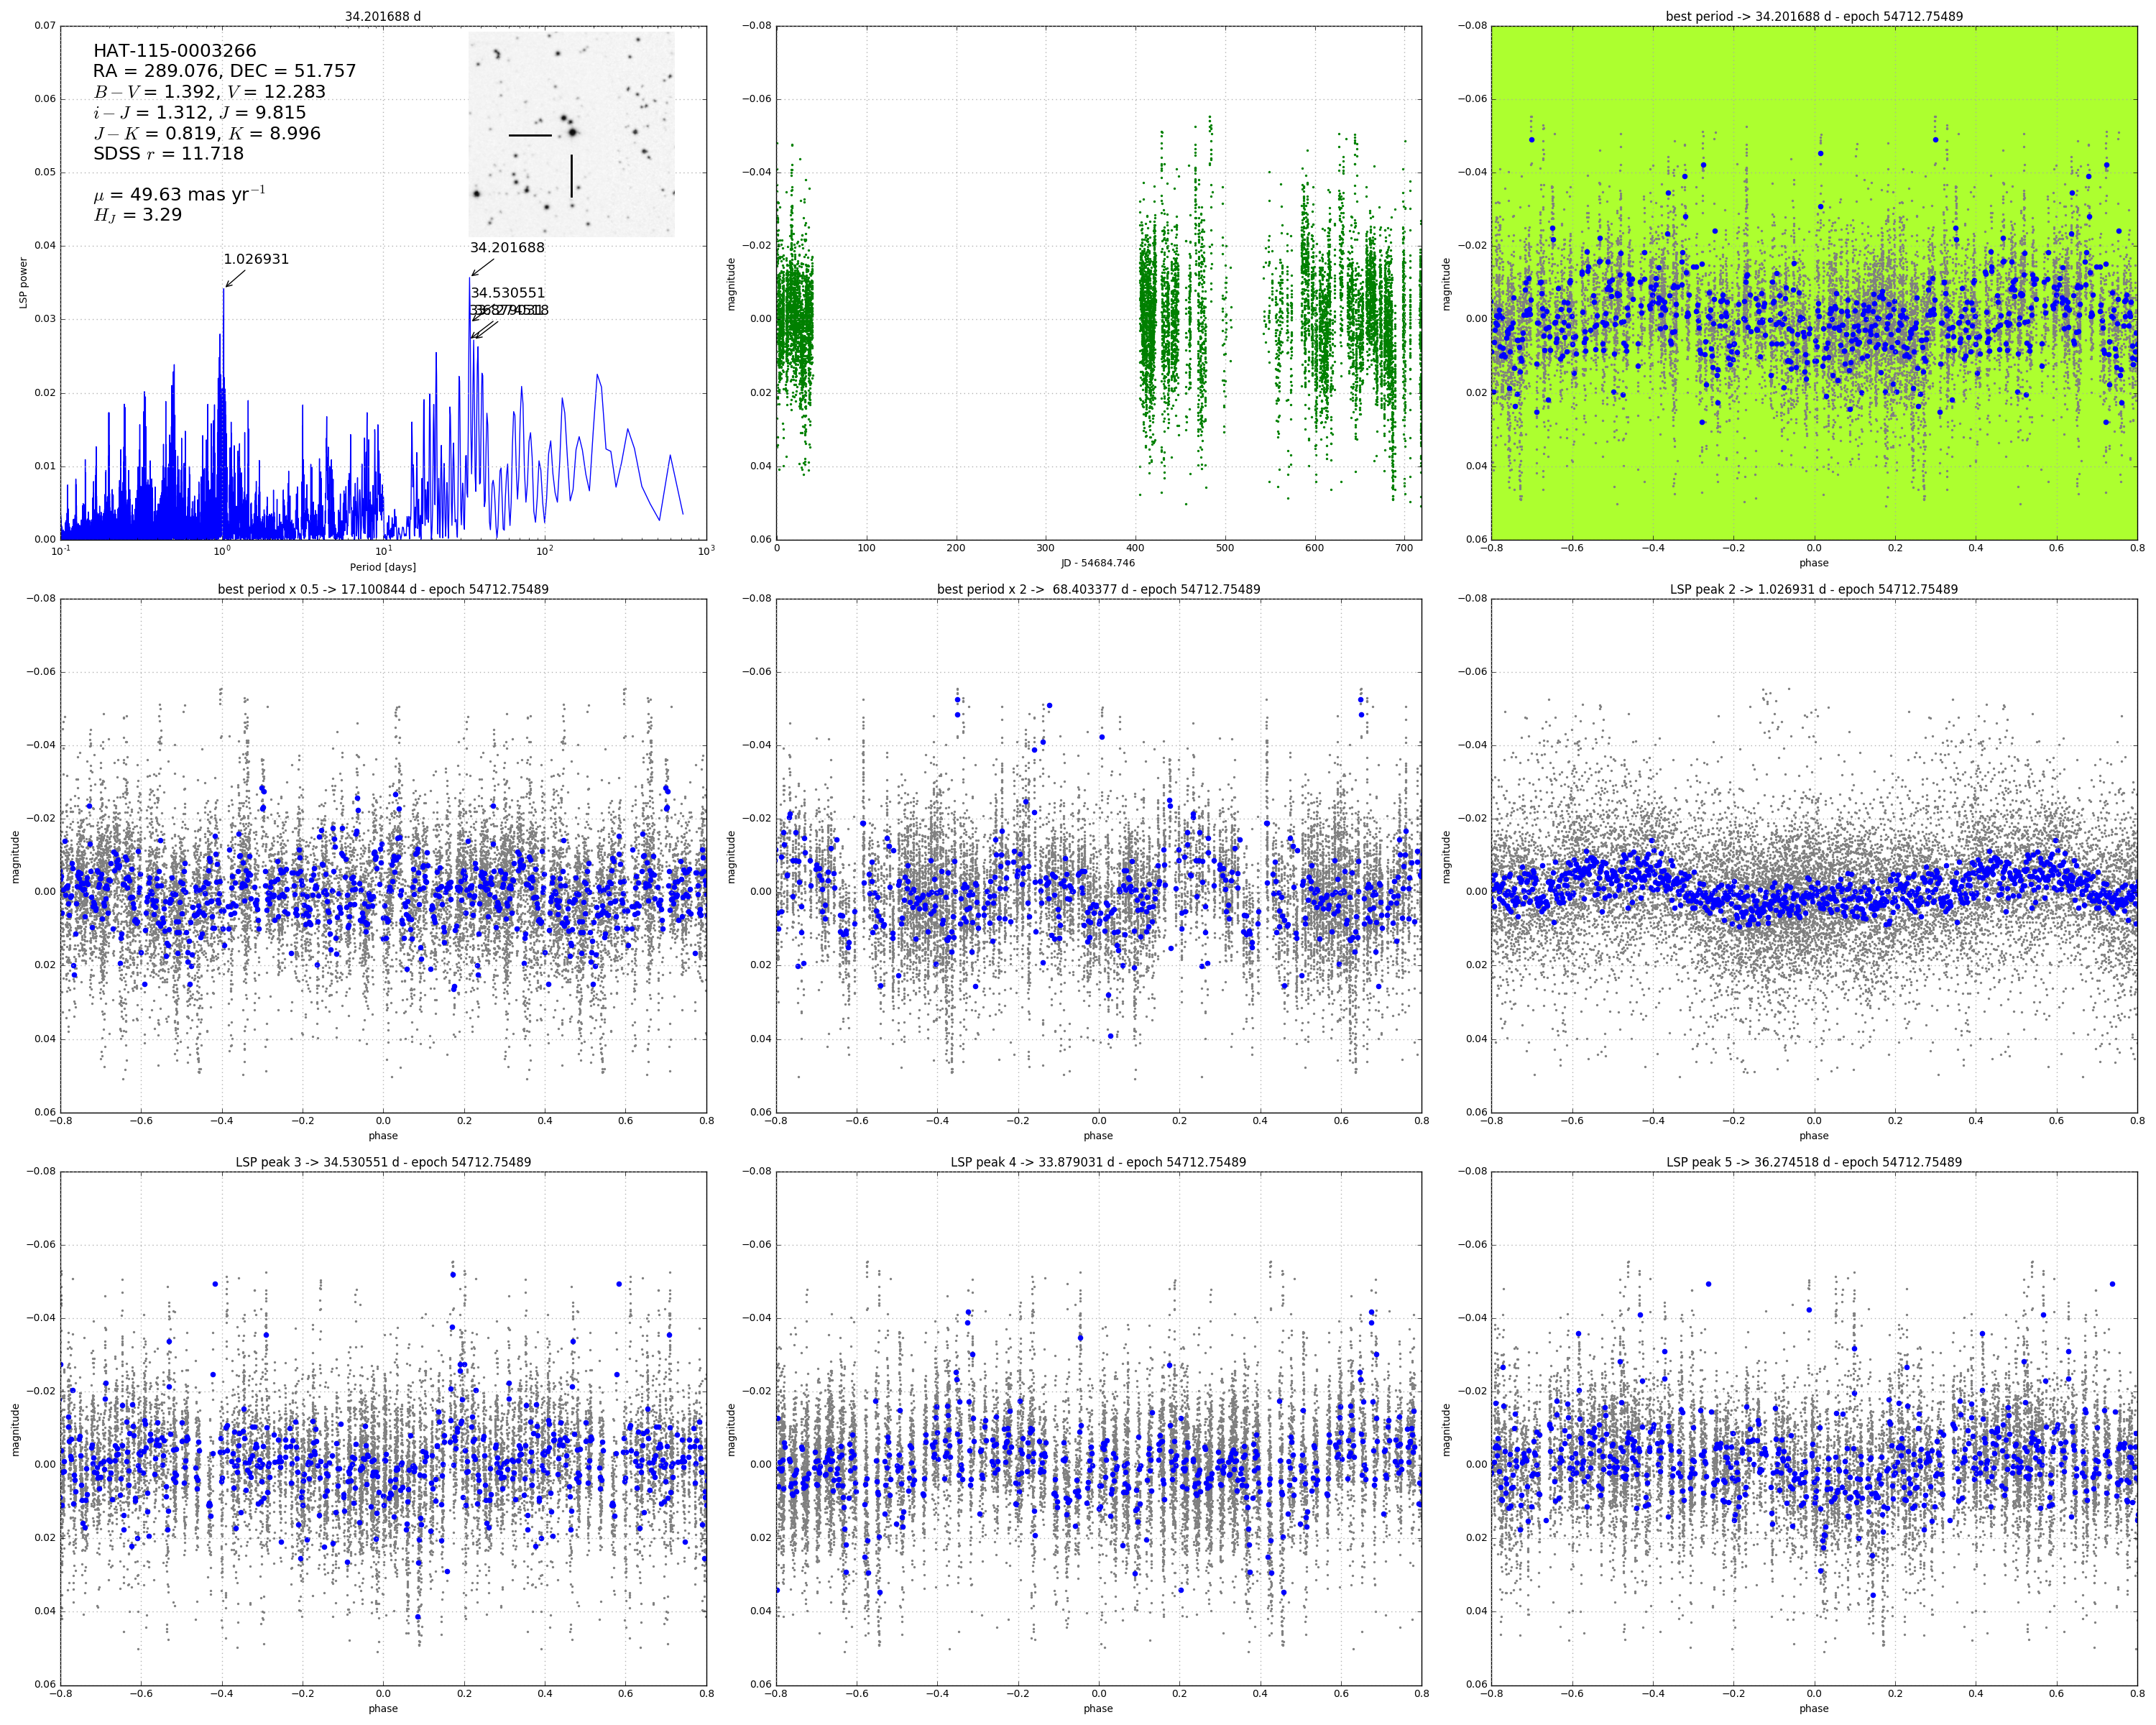

In [27]:
Image('checkplot.png')

In [28]:
# the Generalized Lomb-Scargle usually gets the period wrong for eclipsing binaries as this object appears to be
# let's try the Stellingwerf Phase-Dispersion Minimization method instead
spdm = periodbase.stellingwerf_pdm(times,mags,errs)

2016-12-21T15:56:57.010653Z [INFO]: sigclip = 10.0: before = 9569 observations, after = 9553 observations
2016-12-21T15:56:57.011876Z [INFO]: using autofreq with 35907 frequency points, start P = 0.100, end P = 718.235
2016-12-21T15:56:57.011920Z [INFO]: using 16 workers...


2016-12-21T15:57:59.132841Z [INFO]: adding in object information and finder chart for HAT-115-0003266 at RA: 289.076, DEC: 51.757


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2016-12-21T15:57:59.713897Z [INFO]: sigclip = 4.0: before = 9569 observations, after = 9338 observations
2016-12-21T15:57:59.762672Z [INFO]: sigclip = 30.0: before = 9338 observations, after = 9338 observations
2016-12-21T15:57:59.767531Z [INFO]: spline fit done. nknots = 93,  chisq = 46501.72339, reduced chisq = 5.03048
2016-12-21T15:57:59.767616Z [INFO]: plotting phased LC with period 256.512663, epoch 55163.62093
2016-12-21T15:58:00.665007Z [INFO]: plotting phased LC with period 128.256332, epoch 55163.62093
2016-12-21T15:58:01.598681Z [INFO]: plotting phased LC with period 513.025326, epoch 55163.62093
2016-12-21T15:58:02.503092Z [INFO]: plotting phased LC with period 143.647091, epoch 55163.62093
2016-12-21T15:58:03.578552Z [INFO]: plotting phased LC with period 299.264774, epoch 55163.62093
2016-12-21T15:58:04.473658Z [INFO]: plotting phased LC with period 115.844429, epoch 55163.62093
2016-12-21T15:58:05.383912Z [INFO]: plotting phased LC with period 128.256332, epoch 55163.6209

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


2016-12-21T15:58:10.285837Z [INFO]: checkplot done -> checkplot.png


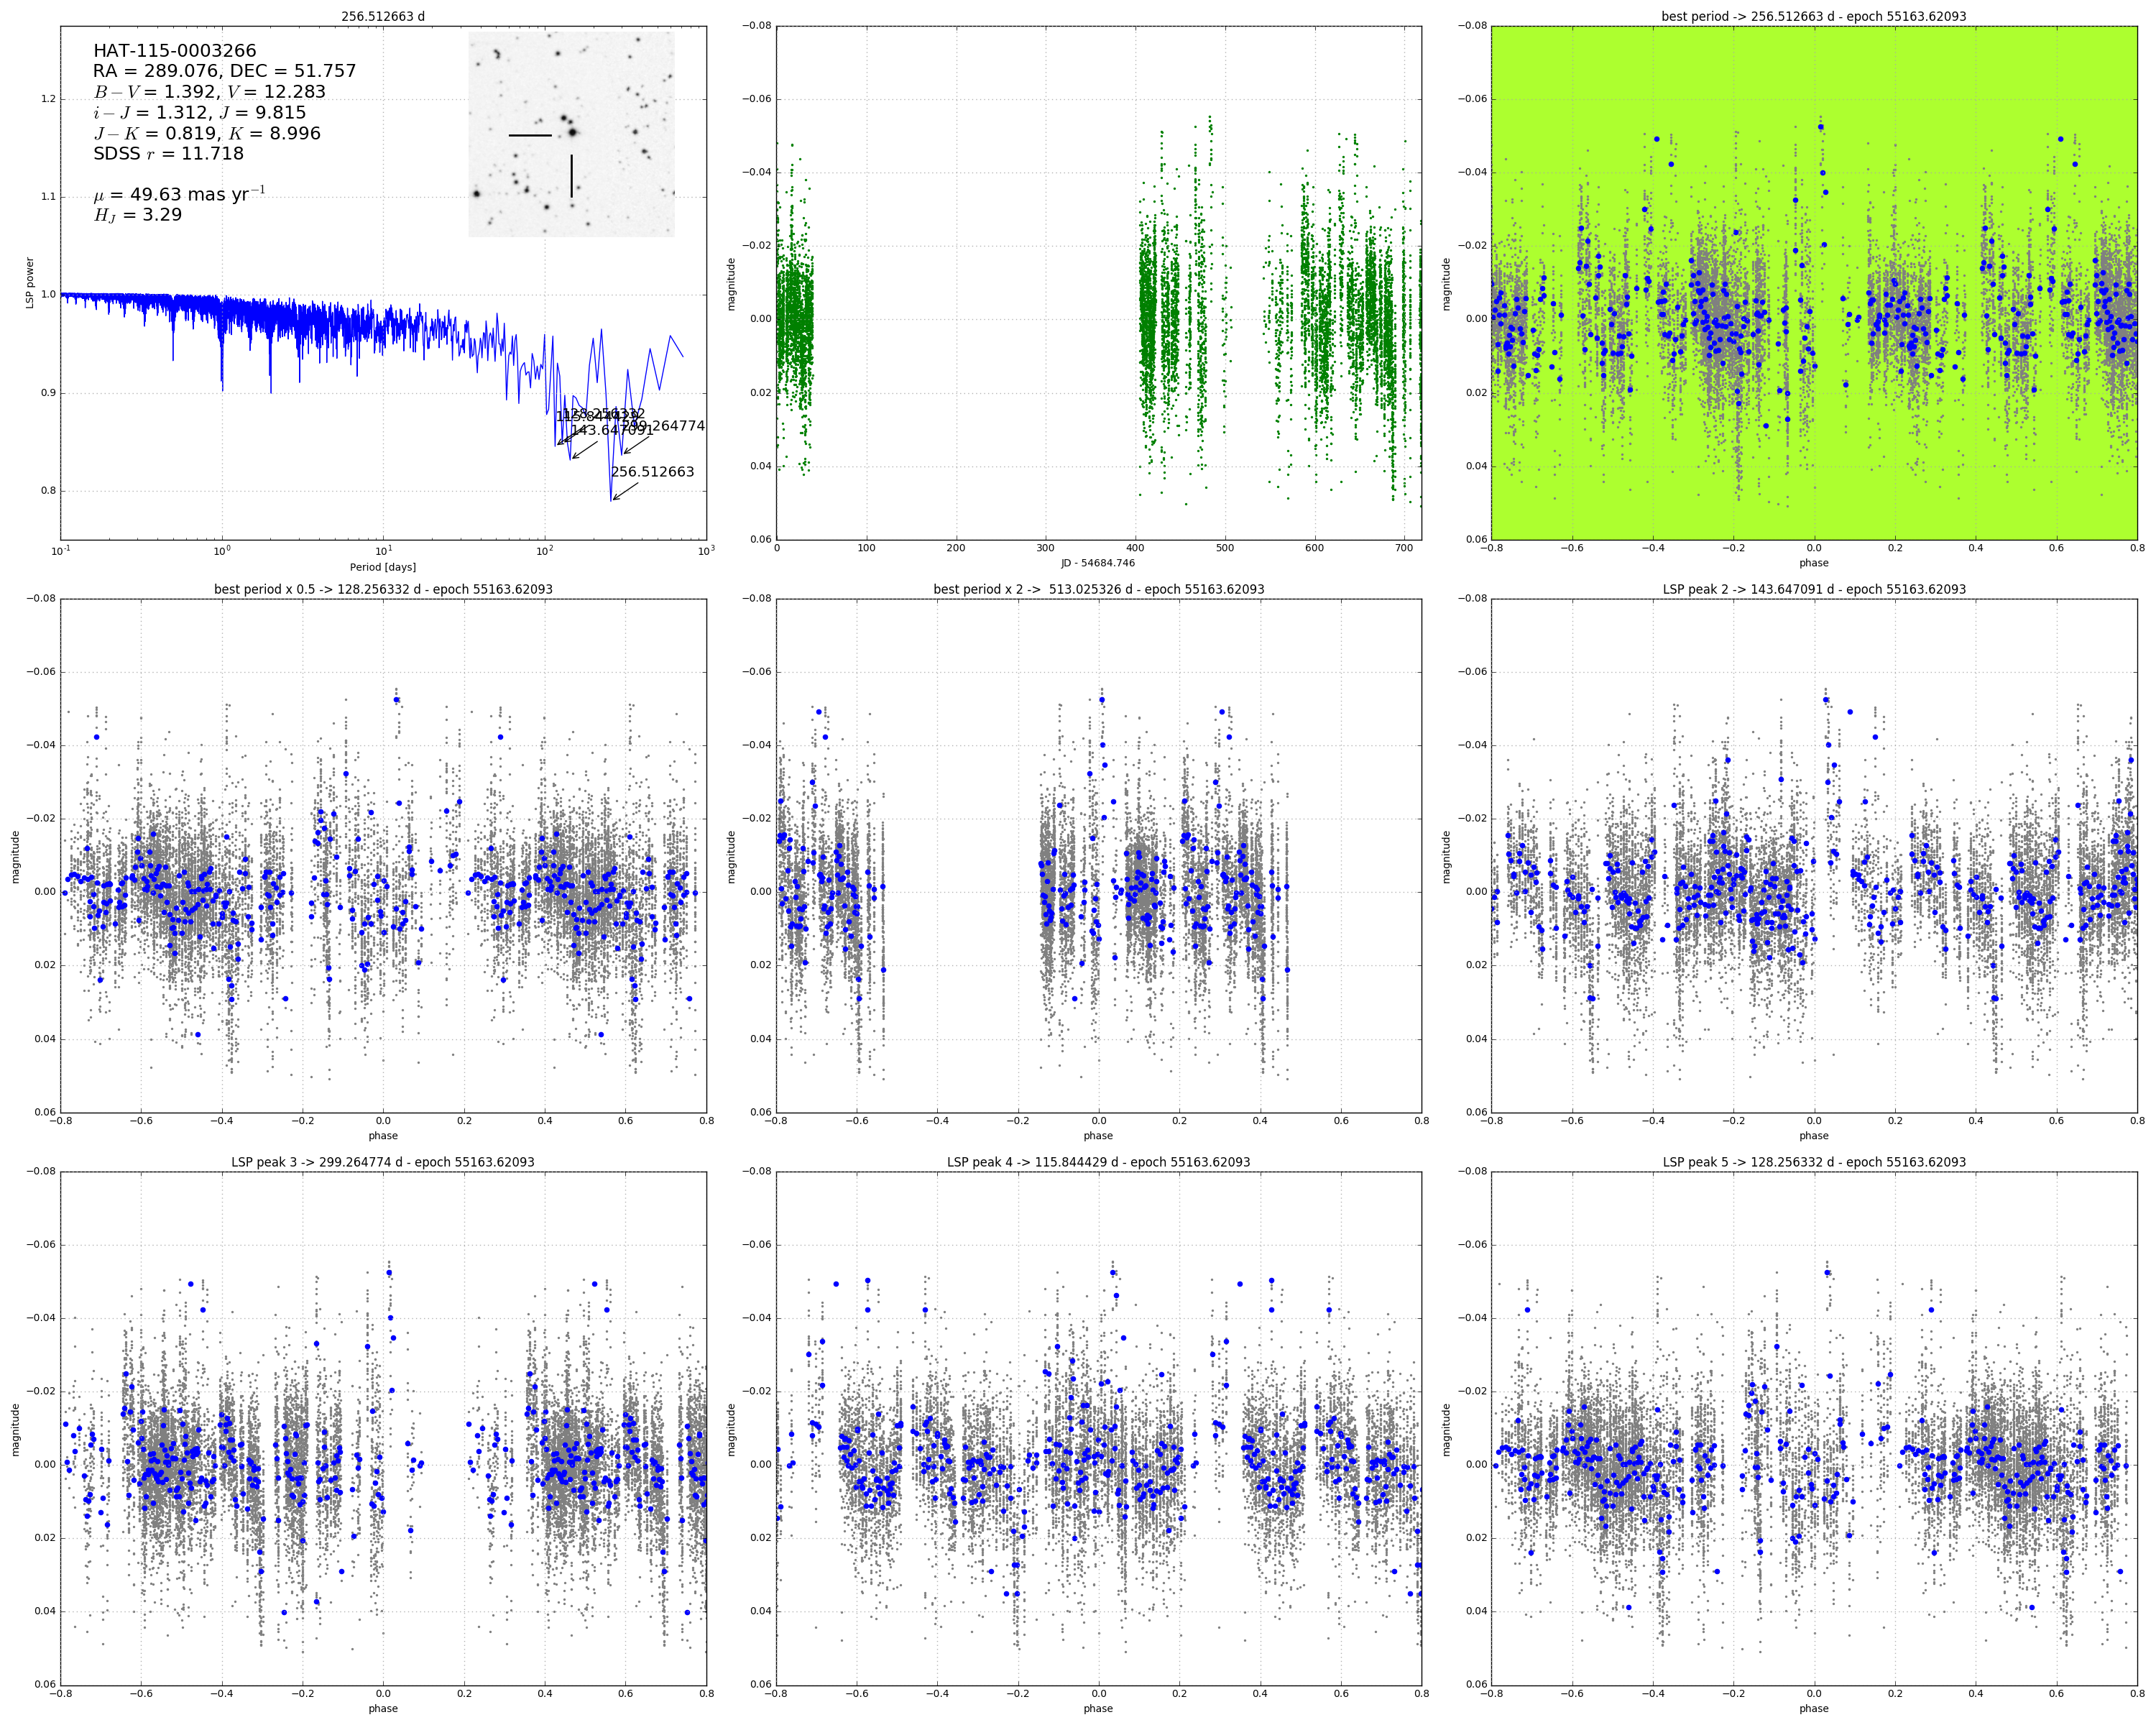

In [30]:
# make the checkplot again
cp = plotbase.make_checkplot(spdm, times, mags, errs, objectinfo=obj_info)
Image('checkplot.png')

BLS would be done as below.

For some reason `autofreq` is giving wonky frequencies. We could choose to debug it right now, but that seems... less important.

This is a $P_\mathrm{orb} = 40\,\mathrm{day}$ eclipsing binary, and the point is that HAT doesn't get the EB periodicity. It almost surely does not get any transits of the ~230day orbital period Kepler-16b.




In [42]:
# that looks pretty bad (actual P_orb = 41d for the binary). 
# let's check using the Box-Least-Squares fitting algorithm by Kovacs et al. (2002)
# let's set the start period to 1.0 days to cut down on the computation we have to do on this poor 4-core machine
blsp = periodbase.bls_parallel_pfind(times,mags,errs,startp=20., endp=80., maxtransitduration=0.15, stepsize=1e-4, autofreq=False)

2016-12-21T16:32:49.661340Z [INFO]: sigclip = 10.0: before = 9569 observations, after = 9553 observations
2016-12-21T16:32:49.661449Z [INFO]: manualfreq: using stepsize: 0.0001, min P: 20.0, max P: 80.0, nfreq: 376, nphasebins: 200, min transit duration: 0.01, max transit duration: 0.15
2016-12-21T16:32:49.661476Z [INFO]: manualfreq: minfreq: 0.0125, maxfreq: 0.05
2016-12-21T16:32:49.661495Z [INFO]: using 16 workers...
2016-12-21T16:32:49.661606Z [INFO]: worker 1: minfreq = 0.013, nfreqs = 24
2016-12-21T16:32:49.661634Z [INFO]: worker 2: minfreq = 0.015, nfreqs = 24
2016-12-21T16:32:49.661654Z [INFO]: worker 3: minfreq = 0.017, nfreqs = 24
2016-12-21T16:32:49.661672Z [INFO]: worker 4: minfreq = 0.020, nfreqs = 24
2016-12-21T16:32:49.661691Z [INFO]: worker 5: minfreq = 0.022, nfreqs = 24
2016-12-21T16:32:49.661711Z [INFO]: worker 6: minfreq = 0.025, nfreqs = 24
2016-12-21T16:32:49.661734Z [INFO]: worker 7: minfreq = 0.027, nfreqs = 24
2016-12-21T16:32:49.661752Z [INFO]: worker 8: minfre

Process ForkPoolWorker-58:
Process ForkPoolWorker-52:
Process ForkPoolWorker-61:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-59:
Process ForkPoolWorker-62:
Process ForkPoolWorker-53:
Traceback (most recent call last):
  File "/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-56:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-51:
Traceback (most recent call last):
Process ForkPoolWorker-50:


KeyboardInterrupt: 

Process ForkPoolWorker-64:
Process ForkPoolWorker-63:
Process ForkPoolWorker-49:
Process ForkPoolWorker-55:
Traceback (most recent call last):
  File "/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-60:
  File "/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


2016-12-20T18:38:17.303782Z [INFO]: adding in object information and finder chart for HAT-772-0554686 at RA: 219.450, DEC: -56.817


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/astroquery/utils/commons.py:187: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


2016-12-20T18:38:17.955606Z [INFO]: sigclip = 4.0: before = 11261 observations, after = 10565 observations
2016-12-20T18:38:18.010861Z [INFO]: sigclip = 30.0: before = 10565 observations, after = 10565 observations
2016-12-20T18:38:18.017049Z [INFO]: spline fit done. nknots = 100,  chisq = 19541.65218, reduced chisq = 1.86751
2016-12-20T18:38:18.017203Z [INFO]: plotting phased LC with period 3.085607, epoch 56794.66055
2016-12-20T18:38:19.426561Z [INFO]: plotting phased LC with period 1.542803, epoch 56794.66055
2016-12-20T18:38:20.668390Z [INFO]: plotting phased LC with period 6.171213, epoch 56794.66055
2016-12-20T18:38:21.857044Z [INFO]: plotting phased LC with period 1.542756, epoch 56794.66055
2016-12-20T18:38:23.044478Z [INFO]: plotting phased LC with period 6.171077, epoch 56794.66055
2016-12-20T18:38:24.354659Z [INFO]: plotting phased LC with period 9.256583, epoch 56794.66055
2016-12-20T18:38:25.538725Z [INFO]: plotting phased LC with period 4.628186, epoch 56794.66055


/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


2016-12-20T18:38:30.481767Z [INFO]: checkplot done -> checkplot.png


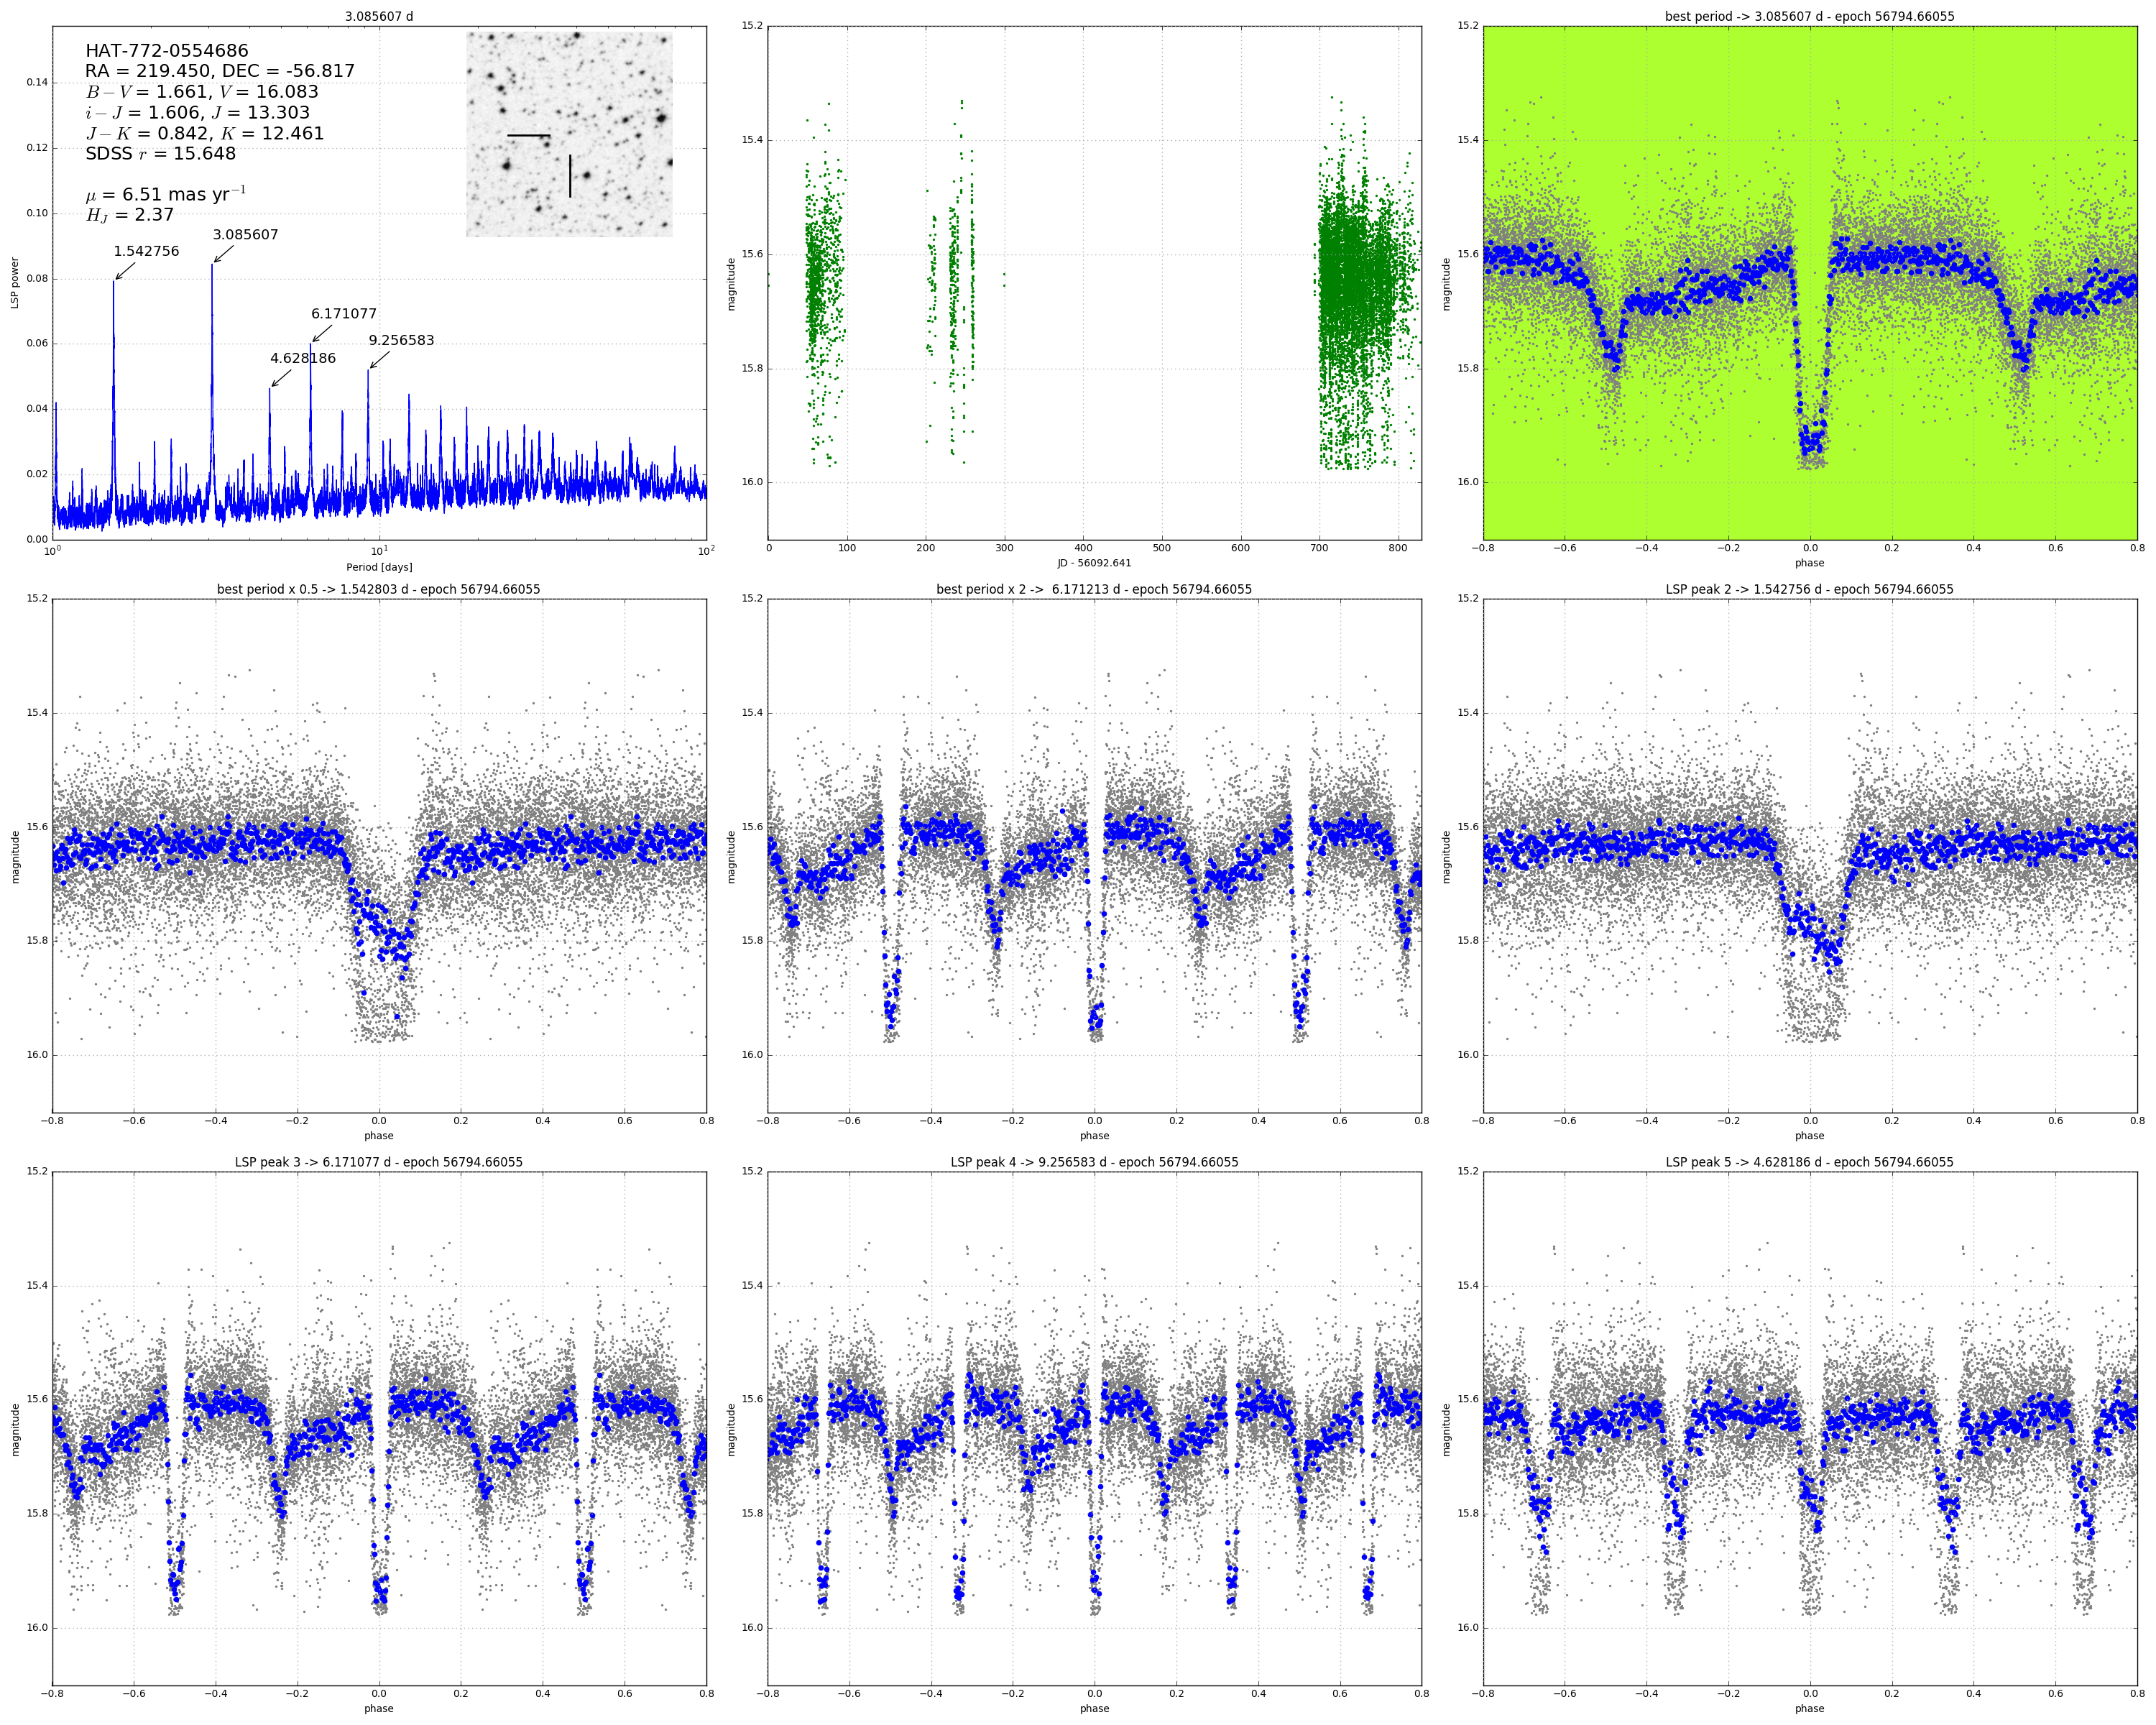

In [14]:
# make another checkplot
cp = plotbase.make_checkplot(blsp, times, mags, errs, objectinfo=normlcd['objectinfo'])
Image('checkplot.png')